In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

from zipfile import ZipFile
import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# -------------------- DATA EXTRACTION --------------------
data_path = '/content/drive/MyDrive/Research/archive/cell_images/cell_images'


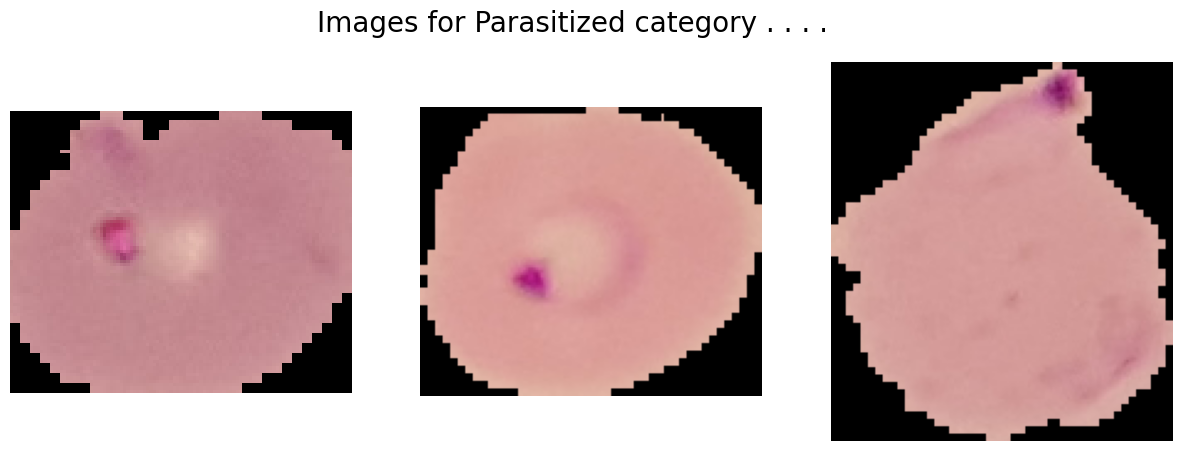

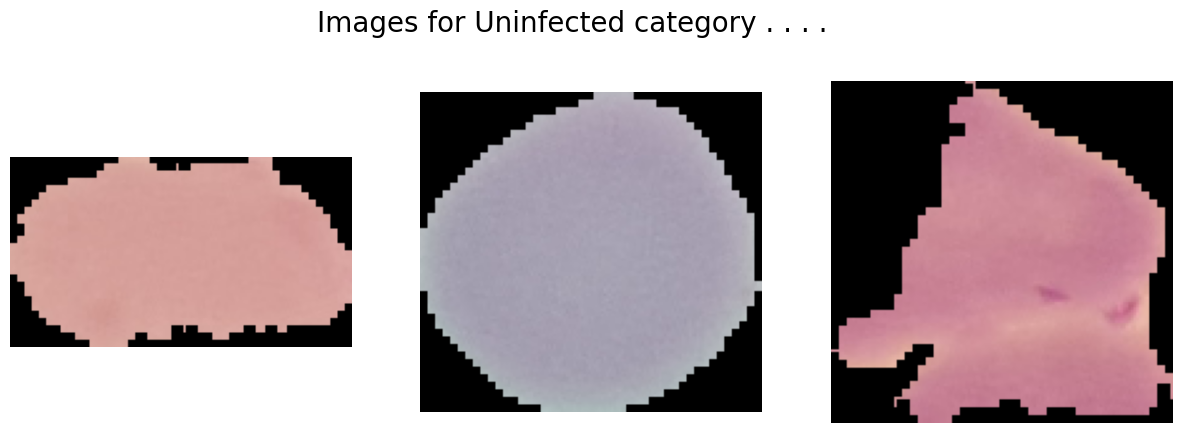

In [ ]:
path = data_path
classes = ['Parasitized','Uninfected']

for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        # Ensure to import Image from PIL for Image.open
        from PIL import Image
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [ ]:
import os

print("Path exists:", os.path.exists(path))
print("Folders:", os.listdir(path))


Path exists: True
Folders: ['Parasitized', 'Uninfected']


In [ ]:

IMG_SIZE = 256
LIMIT = 2000   # <= set limit per class
SPLIT = 0.2

X = []
Y = []

for i, cat in enumerate(classes):
    extensions = ['*.jpeg', '*.jpg', '*.png']
    images_for_current_cat = []

    for ext in extensions:
        images_for_current_cat.extend(glob(f'{path}/{cat}/{ext}'))

    print(cat, "total images found:", len(images_for_current_cat))

    # Limit number of images per class
    images_for_current_cat = images_for_current_cat[:LIMIT]
    print(cat, "using images:", len(images_for_current_cat))

    for image_path in images_for_current_cat:
        img = cv2.imread(image_path)
        X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
        Y.append(i)

X = np.asarray(X)
Y = np.array(Y)

from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=SPLIT, random_state=2022
)


Parasitized total images found: 13780
Parasitized using images: 2000
Uninfected total images found: 13779
Uninfected using images: 2000


In [ ]:
model = keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMG_SIZE,
                               IMG_SIZE,
                               3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.BatchNormalization(),
    layers.Dense(2, activation='softmax')
])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,872,898 (64.36 MB)

 Trainable params: 16,872,642 (64.36 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True


es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

In [ ]:
model.compile(keras.optimizers.Adam(learning_rate=5e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

# Convert labels to one-hot encoding
Y_train_one_hot = tf.keras.utils.to_categorical(Y_train, num_classes=len(classes))
Y_val_one_hot = tf.keras.utils.to_categorical(Y_val, num_classes=len(classes))

# Re-compile the model to ensure proper re-initialization of the training function
model.compile(keras.optimizers.Adam(learning_rate=5e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train_one_hot,
                    validation_data = (X_val, Y_val_one_hot),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 600s 6s/step - accuracy: 0.5171 - loss: 0.8935 - val_accuracy: 0.5775 - val_loss: 0.7174
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 591s 6s/step - accuracy: 0.5726 - loss: 0.7728 - val_accuracy: 0.5775 - val_loss: 0.7300
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 615s 6s/step - accuracy: 0.5650 - loss: 0.7526 - val_accuracy: 0.5113 - val_loss: 0.8173
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 565s 6s/step - accuracy: 0.5669 - loss: 0.7312 - val_accuracy: 0.6200 - val_loss: 0.6806
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 563s 6s/step - accuracy: 0.5934 - loss: 0.6925 - val_accuracy: 0.5300 - val_loss: 0.7755
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 554s 6s/step - accuracy: 0.5868 - loss: 0.6893 - val_accuracy: 0.5462 - val_loss: 0.7028
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 563s 6s/step - accuracy: 0.5873 - loss: 0.6716 - val_accuracy: 0.6250 - val_loss: 0.6641
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 566s 6s/step - accuracy: 0.5942 - loss: 0.6723 - val_accu

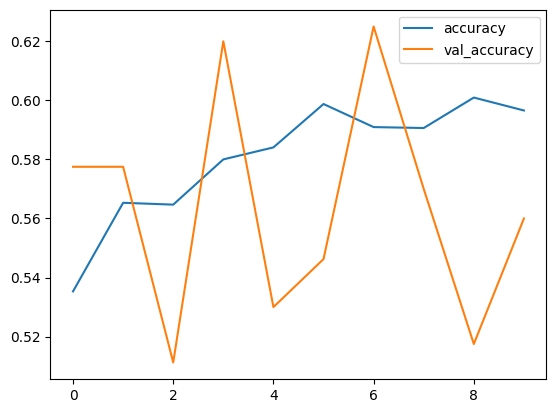

In [ ]:

history_df = pd.DataFrame(history.history)
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()


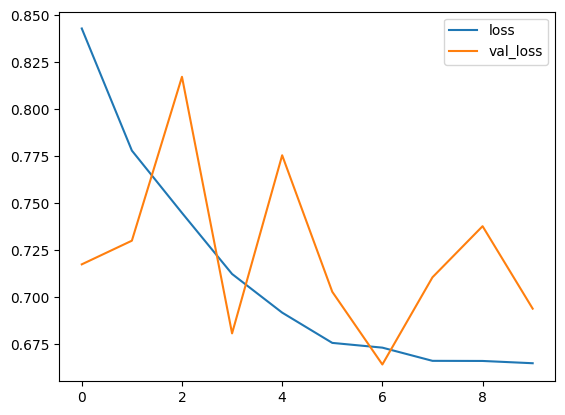

In [ ]:

history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
plt.show()



In [ ]:

Y_pred = model.predict(X_val)
Y_pred = np.argmax(Y_pred, axis=1)
print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=classes))

25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step
              precision    recall  f1-score   support

 Parasitized       0.64      0.26      0.36       396
  Uninfected       0.54      0.86      0.66       404

    accuracy                           0.56       800
   macro avg       0.59      0.56      0.51       800
weighted avg       0.59      0.56      0.52       800



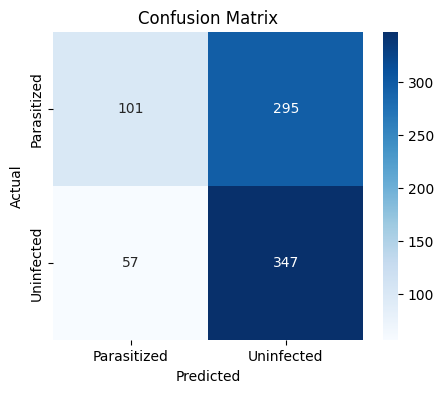

In [ ]:

from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_val, Y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()